## CatBoost 모델링

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 1) 데이터 로드
DF_PATH = "test_data_10.csv"
df = pd.read_csv(DF_PATH)

# 2) 컬럼 설정
target_col = "상영일수"
movie_col  = "영화명"

# 3) 피처 분류
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)
cat_feats = df.select_dtypes(include=[object]).columns.tolist()
if movie_col in cat_feats:
    cat_feats.remove(movie_col)

# 4) 결측치 처리 및 카테고리 인코딩
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
for c in cat_feats:
    df[c] = df[c].fillna("missing").astype('category').cat.codes

# 5) 입력/타겟 분리
X = df[numeric_cols + cat_feats]
y = df[target_col]

# 6) 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7) CatBoost 모델 훈련
cat_feat_idxs = [X_train.columns.get_loc(c) for c in cat_feats]
model = CatBoostRegressor(
    depth=6,                # 기본값
    learning_rate=0.03,     # 기본값
    l2_leaf_reg=3,          # 기본값
    iterations=1000,        # 기본값
    verbose=0               # 기본값 (출력 없음)
)
model.fit(X_train, y_train)

# 8.1) 전체 데이터 성능 평가
test_preds = model.predict(X_test)
mae_test  = mean_absolute_error(y_test, test_preds)
r2_test   = r2_score(y_test, test_preds)
print(f"▶ 테스트 MAE: {mae_test:.3f}, 테스트 R²: {r2_test:.3f}")

# 9) 모델 저장
model.save_model('catboost_model.cbm')

▶ 테스트 MAE: 4.766, 테스트 R²: 0.596


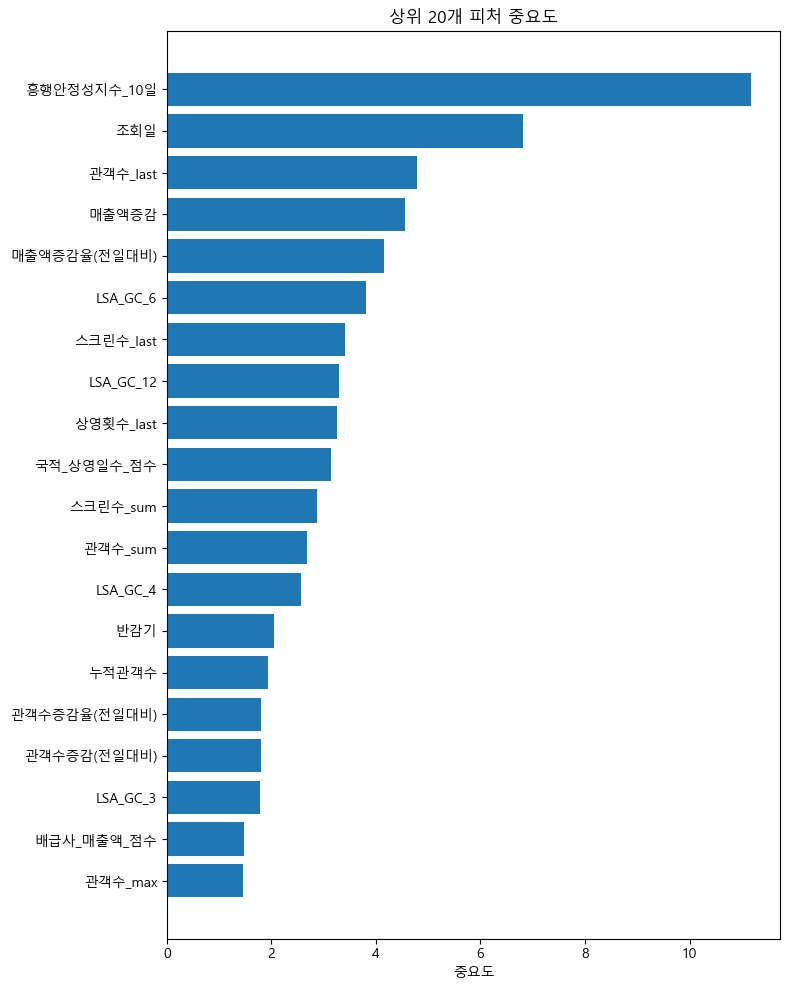

In [4]:
import pandas as pd
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# --- 한글 폰트 설정 ---
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기본 한글 폰트
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux (예: Colab)
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 1) 모델 로드
model = CatBoostRegressor()
model.load_model('catboost_model.cbm')

# 2) 원본 데이터에서 피처 이름 불러오기
df = pd.read_csv("test_data_10.csv")
target_col = "상영일수"
movie_col  = "영화명"

numeric_cols = df.select_dtypes(include=[float, int]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)
cat_feats = df.select_dtypes(include=[object]).columns.tolist()
if movie_col in cat_feats:
    cat_feats.remove(movie_col)

feature_names = numeric_cols + cat_feats

# 3) 중요도 가져와서 상위 20개 선택
importances = model.get_feature_importance()
fi = pd.Series(importances, index=feature_names)
top20 = fi.sort_values(ascending=False).head(20)

# 4) 시각화
plt.figure(figsize=(8, 10))
plt.barh(top20.index[::-1], top20.values[::-1])
plt.title("상위 20개 피처 중요도")
plt.xlabel("중요도")
plt.tight_layout()
plt.show()


### XAI 1. LIME

In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import lime.lime_tabular as lime_tabular

# 1) 데이터 & 모델 로드
DF_PATH = "test_data_10.csv"
df = pd.read_csv(DF_PATH)
model = CatBoostRegressor()
model.load_model('catboost_model.cbm')

# 2) 동일한 전처리
target_col = "상영일수"
movie_col  = "영화명"
# 수치형⋅범주형 컬럼 구분
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)
cat_feats = df.select_dtypes(include=[object]).columns.tolist()
if movie_col in cat_feats:
    cat_feats.remove(movie_col)
# 결측치 & 인코딩
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())
for col in cat_feats:
    df[col] = df[col].fillna("missing").astype('category').cat.codes

X = df[numeric_cols + cat_feats]
y = df[target_col]
movies = df[movie_col]

# 3) LIME Explainer 준비
cat_feat_idxs = [X.columns.get_loc(c) for c in cat_feats]
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns.tolist(),
    categorical_features=cat_feat_idxs,
    mode="regression"
)

def predict_fn(X_array):
    df_tmp = pd.DataFrame(X_array, columns=X.columns)
    for c in cat_feats:
        df_tmp[c] = df_tmp[c].astype(int)
    return model.predict(df_tmp)

In [6]:
# 4) 샘플 설명 생성 및 출력
idx = 10  # 11번째 샘플
exp = explainer.explain_instance(
    data_row=X.iloc[idx].values,
    predict_fn=predict_fn,
    num_features=10
)
# 콘솔 정보
print(f"🎬 영화명       : {movies.iloc[idx]}")
print(f"📈 예측 상영일수 : {predict_fn(X.iloc[idx].values.reshape(1,-1))[0]:.2f}")
print(f"📊 실제 상영일수 : {y.iloc[idx]}\n")

# 인터랙티브 시각화 (Jupyter)
exp.show_in_notebook(show_table=True)

🎬 영화명       : 극장판 하이큐!! 쓰레기장의 결전
📈 예측 상영일수 : 251.78
📊 실제 상영일수 : 264



모델은 이 영화의 상영일수를 251.78일로 예측했으며, 실제 상영일수는 264일로 매우 근접한 값을 보였다.
모델이 이렇게 예측한 데는 여러 요인이 작용했다.

누적 관객수가 3584명, 전일 대비 관객수 증가폭이 3627명, 매출 점유율이 1667, 전일 대비 매출 증가율이 2471 등 흥행을 잘 나타내는 지표들이 모두 높은 수준을 보였고, 관객 수의 추세(slope)나 마지막 관객 수, 상영 횟수 등의 지표들도 기준 이상을 충족하며 긍정적인 영향을 주었다. 이들은 모두 모델이 해당 영화를 장기 상영 가능성이 높다고 판단하는 데 기여한 요소들이다. 

반면, '흥행안정성지수_10일'이라는 지표 값은 다소 부정적인 신호로 작용하여 모델의 예측값을 일부 낮추는 방향으로 영향을 주었다.

In [7]:
# 4) 샘플 설명 생성 및 출력
idx = 102  # 103번째 샘플
exp = explainer.explain_instance(
    data_row=X.iloc[idx].values,
    predict_fn=predict_fn,
    num_features=10
)
# 콘솔 정보
print(f"🎬 영화명       : {movies.iloc[idx]}")
print(f"📈 예측 상영일수 : {predict_fn(X.iloc[idx].values.reshape(1,-1))[0]:.2f}")
print(f"📊 실제 상영일수 : {y.iloc[idx]}\n")

# 인터랙티브 시각화 (Jupyter)
exp.show_in_notebook(show_table=True)

🎬 영화명       : 탈주
📈 예측 상영일수 : 83.59
📊 실제 상영일수 : 88



여기서는 위의 영화와 달리 흥행안정성지수가 긍정적인 영향을 주었다. 흥행안정성지수가 높다는 것은 단기적으로 관객 수요가 꾸준하고, 상영 안정성도 높다는 것을 의미하기 때문에, 흥행이 안정적이면 곧, 상영일이 늘어날 수 있다는 해석이 도출된 것 같다.

In [8]:
# 4) 샘플 설명 생성 및 출력
idx = 101  # 102번째 샘플
exp = explainer.explain_instance(
    data_row=X.iloc[idx].values,
    predict_fn=predict_fn,
    num_features=10
)
# 콘솔 정보
print(f"🎬 영화명       : {movies.iloc[idx]}")
print(f"📈 예측 상영일수 : {predict_fn(X.iloc[idx].values.reshape(1,-1))[0]:.2f}")
print(f"📊 실제 상영일수 : {y.iloc[idx]}\n")

# 인터랙티브 시각화 (Jupyter)
exp.show_in_notebook(show_table=True)

🎬 영화명       : 기적
📈 예측 상영일수 : 66.45
📊 실제 상영일수 : 88



'기적'과 같은 경우, 전반적으로 흥행 흐름이 보수적으로 평가 되었음을 보여준다.
관객수, 흥행안정성지수, 상영횟수 등의 지표가 매우 양호하지만, 제작사나 내부 순위 등의 요소가 흥행이 좋지 않았던 패턴과 유사하여 부정적인 영향이 반영된 것으로 보인다. 

### XAI 2. SHAP

In [9]:
# shap_analysis.py

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

DF_PATH       = "test_data_10.csv"
MODEL_PATH    = "catboost_model.cbm"
TARGET_COL    = "상영일수"
MOVIE_COL     = "영화명"
TEST_SIZE     = 0.2
RANDOM_STATE  = 42

# 2) 데이터 로드 및 전처리 (모델 훈련 때와 동일)
df = pd.read_csv(DF_PATH)

# 수치형/범주형 컬럼 분리
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)
cat_feats = df.select_dtypes(include=[object]).columns.tolist()
if MOVIE_COL in cat_feats:
    cat_feats.remove(MOVIE_COL)

# 결측치 처리
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
for c in cat_feats:
    df[c] = df[c].fillna("missing").astype('category').cat.codes

# 입력/타겟 분리
X = df[numeric_cols + cat_feats]
y = df[TARGET_COL]

# 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# 3) 저장된 모델 불러오기
model = CatBoostRegressor()
model.load_model(MODEL_PATH)

# 4) SHAP 분석

# 4.1) TreeExplainer 생성
explainer = shap.TreeExplainer(model)

# 4.2) SHAP 값 계산 (X_test 전체)
shap_values = explainer.shap_values(X_test)

# 4.3) SHAP 요약 플롯 (dot plot)
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=X_test.columns, 
    show=False
)
plt.title("SHAP Summary Plot (dot)")
plt.tight_layout()
plt.show()

# 4.4) SHAP 바 차트 (bar plot)
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=X_test.columns, 
    plot_type="bar", 
    show=False
)
plt.title("SHAP Feature Importance (bar)")
plt.tight_layout()
plt.show()



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


가장 눈에 띄는 점은 ‘흥행안정성지수_10일’이 예측에 가장 큰 영향을 미쳤다는 것이다. 이 변수는 모델이 상영일수를 판단할 때 가장 중요한 기준으로 활용한 지표이며, 값이 클수록 예측 상영일수가 증가하는 경향을 강하게 보였다. 이는 개봉 후 10일간의 흥행 흐름이 안정적일수록 장기 상영이 가능하다고 모델이 판단했다는 의미로 해석할 수 있다.

다음으로 ‘관객수_last’, 즉 마지막 관객 수가 중요한 변수로 나타났다. 이 변수 역시 값이 높을수록 예측 상영일수에 긍정적인 영향을 미쳤다. 이는 개봉 후 후반부에도 관객 수가 유지된다면 상영이 더 길게 이어질 가능성이 크다는 뜻으로 읽힌다.

이 외에도 ‘스크린수_last’와 ‘스크린수_sum’, ‘관객수_sum’, ‘상영횟수_last’ 등이 상영일수에 유의미한 영향을 준 변수로 나타났다. 이들 변수는 스크린 확보 수준, 누적 관객 수, 그리고 마지막 시점의 상영 횟수 등을 반영하고 있으며, 대체로 상영 환경이 안정적이고 관객 수요가 꾸준할수록 상영일수가 늘어난다는 경향을 보여준다.

요약하면, 이 SHAP 분석을 통해 모델이 상영일수를 예측할 때 ‘초기 흥행 안정성’, ‘최근 관객 수’, ‘스크린 및 상영 환경’과 같은 변수에 가장 의존하고 있다는 것을 알 수 있다. 이는 상영일수라는 결과가 단순히 한두 지표에 의해서가 아니라, 흥행의 지속성, 확장성, 안정성이라는 요소들이 복합적으로 작용하고 있다는 사실을 시사한다.